# Semana 4 – DBSCAN com Wine 🍷

Clustering por densidade com o dataset Wine, comparável ao seu experimento de K-Means.
Inclui: padronização, k-dist plot, DBSCAN, métricas (Silhouette/ARI), e visualização em PCA.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
import warnings
warnings.filterwarnings('ignore')

## 1) Carregar e padronizar dados

In [2]:
wine = load_wine()
X_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
y_wine = wine.target  # só para avaliação opcional

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_wine)
print("Shape:", X_scaled.shape)

Shape: (178, 13)


## 2) k-dist plot para escolha de eps
- k = min_samples (regra de bolso: ~2 * n_features)
- Olhar o “joelho” da curva para um bom eps inicial

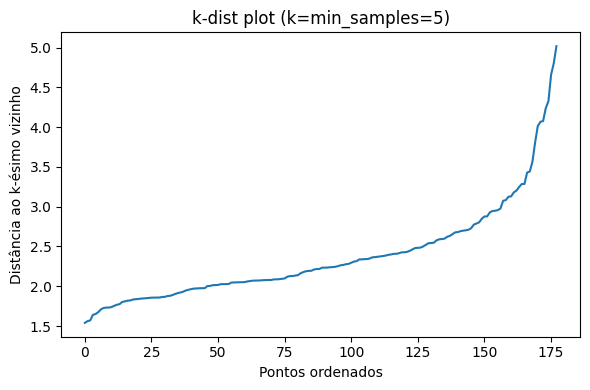

Sugestão: escolha eps próximo ao 'joelho' desse gráfico.


In [16]:
n_features = X_scaled.shape[1]
min_samples = max(5, 2 * n_features)  # regra de bolso # regra de bolso não funcionou muito bem aqui
min_samples = 5
k = min_samples

nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
k_dists = np.sort(distances[:, -1])  # distância ao k-ésimo vizinho

plt.figure(figsize=(6,4))
plt.plot(k_dists)
plt.title(f"k-dist plot (k=min_samples={min_samples})")
plt.ylabel("Distância ao k-ésimo vizinho")
plt.xlabel("Pontos ordenados")
plt.tight_layout(); plt.show()

print("Sugestão: escolha eps próximo ao 'joelho' desse gráfico.")

## 3) Rodar DBSCAN (ajuste eps conforme seu k-dist)
- Tente alguns valores de `eps` em torno do joelho (ex.: 1.2, 1.4, 1.6...).
- `min_samples` já definido acima pela regra de bolso, ajuste se necessário.

In [17]:
# Faça uma pequena busca manual de eps
eps_candidates = [2.150, 2.155, 2.160, 2.165, 2.170]
results = []
for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    # silhouette só faz sentido se n_clusters >= 2 e todos os pontos não forem ruído
    sil = np.nan
    if n_clusters >= 2 and n_clusters < len(np.unique(labels)) and np.any(labels != -1):
        try:
            sil = silhouette_score(X_scaled[labels!=-1], labels[labels!=-1])
        except Exception:
            sil = np.nan
    # ARI só para referência (usa y verdadeiro)
    ari = adjusted_rand_score(y_wine, labels)
    results.append((eps, n_clusters, n_noise, sil, ari))

res_df = pd.DataFrame(results, columns=["eps", "n_clusters", "n_noise", "silhouette", "ARI"])
print(res_df)

# escolha um eps a partir da tabela/plot acima
best_row = res_df.sort_values(by=["silhouette", "ARI"], ascending=False).iloc[0]
chosen_eps = float(best_row.eps)
print("\nEscolhendo eps=", chosen_eps, "(com base no melhor silhouette/ARI dentre os candidatos)")

dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)
labels_db = dbscan.fit_predict(X_scaled)
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print("Clusters encontrados:", n_clusters, "| Ruído (-1):", np.sum(labels_db==-1))

     eps  n_clusters  n_noise  silhouette       ARI
0  2.150           3       60    0.220087  0.276673
1  2.155           3       58    0.218136  0.267540
2  2.160           3       58    0.218136  0.267540
3  2.165           2       56    0.348515  0.332110
4  2.170           2       56    0.348515  0.332110

Escolhendo eps= 2.165 (com base no melhor silhouette/ARI dentre os candidatos)
Clusters encontrados: 2 | Ruído (-1): 56


## 4) Visualização em 2D (PCA) e métricas
- Cores por cluster; ruído = cor distinta (-1)
- Métricas: Silhouette (sem ruído), ARI/Homogeneity/Completeness/V-measure (referência com y)

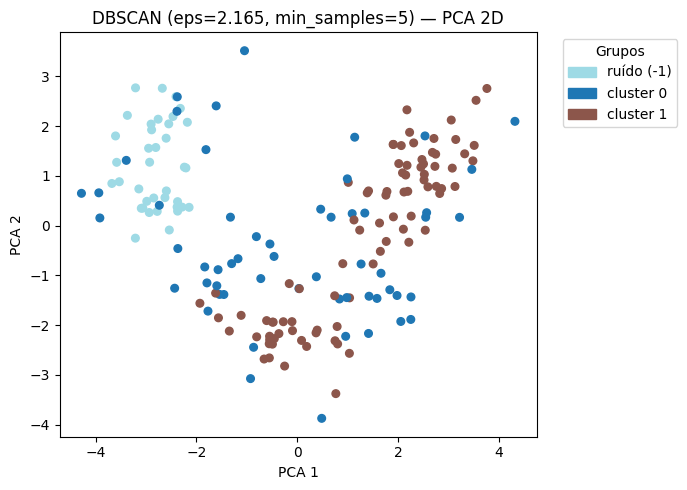

Silhouette (sem ruído): 0.34851496810634475
ARI: 0.3321104837551175
Homogeneity: 0.412497689502875
Completeness: 0.429393076965745
V-measure: 0.42077585166983056


In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

labels = labels_db
unique_labs = np.unique(labels)
n_colors = max(3, len(unique_labs))
cmap = plt.get_cmap('tab20', n_colors)

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels,
    cmap=cmap,
    s=30
)
plt.title(f"DBSCAN (eps={chosen_eps}, min_samples={min_samples}) — PCA 2D")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")

# legenda manual (clusters e ruído)
import matplotlib.patches as mpatches
handles = []
for lab in unique_labs:
    color = cmap((lab % n_colors))
    name = f"cluster {lab}" if lab != -1 else "ruído (-1)"
    handles.append(mpatches.Patch(color=color, label=name))
plt.legend(handles=handles, title="Grupos", bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout(); plt.show()

# métricas
if len(set(labels)) - (1 if -1 in labels else 0) >= 2 and np.any(labels != -1):
    sil = silhouette_score(X_scaled[labels!=-1], labels[labels!=-1])
else:
    sil = np.nan
print("Silhouette (sem ruído):", sil)
print("ARI:", adjusted_rand_score(y_wine, labels))
print("Homogeneity:", homogeneity_score(y_wine, labels))
print("Completeness:", completeness_score(y_wine, labels))
print("V-measure:", v_measure_score(y_wine, labels))

## 5) (Opcional) Comparar visualmente com as classes reais (y_wine)

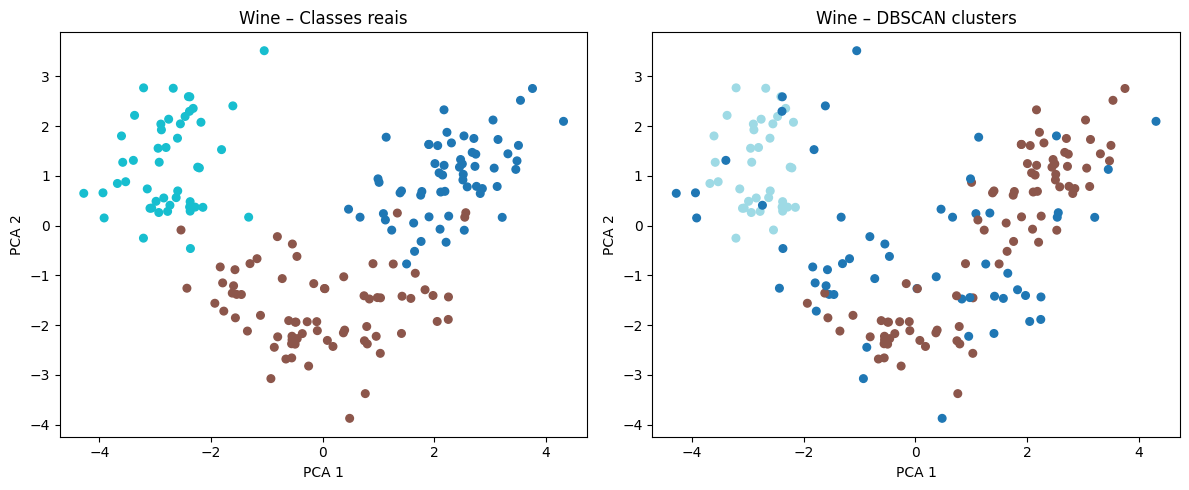

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_wine, cmap='tab10', s=30)
ax[0].set_title('Wine – Classes reais')
ax[0].set_xlabel('PCA 1'); ax[0].set_ylabel('PCA 2')

ax[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap=cmap, s=30)
ax[1].set_title('Wine – DBSCAN clusters')
ax[1].set_xlabel('PCA 1'); ax[1].set_ylabel('PCA 2')

plt.tight_layout(); plt.show()